In [8]:
from pathlib import Path
import pandas as pd
import numpy as np

In [9]:
method_rename_dict = {
        'velocyto': "Velocyto",
        'scvelo_dyn': "scVelo (dyn)",
        'scvelo_stc': "scVelo (stc)",
        'veloae': "VeloAE",
        'dynamo_m1': "Dynamo (m1)",
        'unitvelo_ind': "UniTVelo (ind)",
        'unitvelo_uni': "UniTVelo (uni)",
        'velovae_std': "VeloVAE (std)",
        'velovae_fullvb': "VeloVAE (Full VB)",
        'deepvelo': "DeepVelo",
        'celldancer': "cellDancer",
        'pyrovelocity_m1': "Pyro-Velocity (m1)",
        'pyrovelocity_m2': "Pyro-Velocity (m2)",
        'kvelo': "κ-velo",
        'velovi': "veloVI",
        'cell2fate': "cell2fate",
        'sdevelo': "SDEvelo",
        'svelvetvae': "SvelvetVAE",
        'latentvelo_std': "LatentVelo (std)",
        'tivelo_std': "TIVelo (std)",
        'tivelo_simple': "TIVelo (simple)",
        'sctour_mse': "scTour (MSE)",
        'sctour_nb': "scTour (NB)",
        'sctour_zinb': "scTour (ZINB)",
        'multivelo': "MultiVelo",
        'velvetvae': "VelvetVAE",
        'graphvelo_std': "GraphVelo (std)"
}

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from typing import List, Optional, Tuple, Dict

def plot_four_metric_grid(
    df_1: pd.DataFrame,
    df_2: pd.DataFrame,
    df_3: pd.DataFrame,
    df_4: pd.DataFrame,
    method_order: Optional[List[str]] = None,
    group_colors: Tuple[str, str, str, str] = ("#4C72B0", "#DD8452", "#55A868", "#C44E52"),
    text_colors: Tuple[str, str, str, str] = ("#4C72B0", "#DD8452", "#55A868", "#C44E52"),
    group_alpha: float = 0.10,
    bar_alpha: float = 1.0,
    capsize: float = 2.5,
    fontsize: int = 10,
    figsize: Tuple[float, float] = (18, 0.6),
    dpi: int = 200,
    vlims: Optional[Dict[str, Tuple[float, float]]] = None,
    show_header: bool = True,
    width_ratios: Optional[List[float]] = None,
    alternate_row_bg: bool = True,
    row_bg_light: str = "#fafafa",
    row_bg_dark: str = "#f0f0f0",
    method_rename_dict: Optional[Dict[str, str]] = None,
    show_method_names: bool = True,
):

    dfs = [df_1.copy(), df_2.copy(), df_3.copy(), df_4.copy()]
    for i, d in enumerate(dfs, 1):
        d.columns = ["Method", f"mean1_{i}", f"std1_{i}", f"mean2_{i}", f"std2_{i}", f"rank_{i}"]

    master = dfs[0]
    for d in dfs[1:]:
        master = master.merge(d, on="Method", how="outer")

    master["rank_mean"] = master[[f"rank_{i}" for i in range(1,5)]].mean(axis=1)
    master["overall_rank"] = master["rank_mean"].rank(ascending=True, method="min")

    if method_order is None:
        master = master.sort_values("overall_rank", kind="mergesort")
    else:
        order_map = {m: i for i, m in enumerate(method_order)}
        master["__ord__"] = master["Method"].map(order_map)
        master = master.sort_values(["__ord__", "overall_rank"], na_position="last")
        master = master.drop(columns="__ord__")

    if method_rename_dict is not None:
        master["Method"] = master["Method"].map(lambda x: method_rename_dict.get(x, x))
    methods = master["Method"].tolist()
    n = len(methods)

    if width_ratios is None:
        width_ratios = [3, 0.4, 0.4, 0.4, 0.4, 0.4,
                        1.2, 1.2, 0.8,
                        1.2, 1.2, 0.8,
                        1.2, 1.2, 0.8,
                        1.2, 1.2, 0.8,
                        1.0]

    fig_h = max(figsize[1]*n + (1.0 if show_header else 0.3), 2.0)
    fig = plt.figure(figsize=(figsize[0], fig_h), dpi=dpi)
    total_rows = n + (1 if show_header else 0)
    gs = GridSpec(total_rows, 19, figure=fig, width_ratios=width_ratios, wspace=0.05, hspace=0.0)

    group_cols = [(6,8), (9,11), (12,14), (15,17)]
    start_row = 1 if show_header else 0

    plt.rcParams['axes.facecolor'] = 'none'  # 重置默认背景色
    if alternate_row_bg:
        for i in range(n):
            grid_row = start_row + i
            bbox = gs[grid_row, :].get_position(fig)
            band_color = row_bg_light if (i % 2 == 0) else row_bg_dark
            fig.patches.append(Rectangle(
                (bbox.x0, bbox.y0), bbox.width, bbox.height,
                transform=fig.transFigure, color=band_color,
                zorder=-50, lw=0,
            ))

            # === 新增：在每两行之间画一条更深的线 ===
            if i < n - 1: 
                next_bbox = gs[start_row + i + 1, :].get_position(fig)
                y_line = (bbox.y0 + next_bbox.y1) / 2
                fig.lines.append(mlines.Line2D(
                    [bbox.x0, bbox.x1],
                    [y_line, y_line],
                    transform=fig.transFigure,
                    color="#e6e6e6",   # 比深灰行更深
                    linewidth=1.2,
                    zorder=-40,
                ))
    
    # === 上边框线 === #
    top_bbox = gs[start_row, :].get_position(fig)
    y_top = top_bbox.y1
    fig.lines.append(mlines.Line2D(
        [top_bbox.x0, top_bbox.x1],
        [y_top, y_top],
        transform=fig.transFigure,
        color="#e6e6e6", linewidth=1.2, zorder=-30
    ))

    # === 下边框线 ===
    bottom_bbox = gs[start_row + n - 1, :].get_position(fig)
    y_bottom = bottom_bbox.y0
    fig.lines.append(mlines.Line2D(
        [bottom_bbox.x0, bottom_bbox.x1],
        [y_bottom, y_bottom],
        transform=fig.transFigure,
        color="#e6e6e6", linewidth=1.2, zorder=-30
    ))

    # === 左边框线 ===
    fig.lines.append(mlines.Line2D(
        [top_bbox.x0, top_bbox.x0],
        [bottom_bbox.y0, top_bbox.y1],
        transform=fig.transFigure,
        color="#e6e6e6", linewidth=1.2, zorder=-30
    ))

    # === 右边框线 ===
    fig.lines.append(mlines.Line2D(
        [top_bbox.x1, top_bbox.x1],
        [bottom_bbox.y0, top_bbox.y1],
        transform=fig.transFigure,
        color="#e6e6e6", linewidth=1.2, zorder=-30
    ))

    headers = ["Name", "DL", "Time", "Platform", "Running", "Memory",
               "CBDir", "ICVCoh", "",
               "STS", "NTE", "",
               "CTO", "TSC", "",
               "SSD", "SST", "",
               "Overall"]
    if show_header:
        bar_cols = [6, 7, 9, 10, 12, 13, 15, 16]
        for c in range(19):
            axh = fig.add_subplot(gs[0, c])
            axh.axis("off")
            if c in bar_cols:
                # 左对齐（用于 bar 列）
                axh.text(0, 0.5, headers[c], ha="left", va="center",
                        fontsize=fontsize, fontweight="bold")
            else:
                # 其它列保持居中
                axh.text(0.5, 0.5, headers[c], ha="center", va="center",
                        fontsize=fontsize, fontweight="bold")
            # axh.text(0.5, 0.5, headers[c], ha="center", va="center", fontsize=fontsize, fontweight="bold")

    def get_lim(df_idx, which):
        # 计算横向坐标范围（同时考虑 mean ± std）
        if vlims:
            key = "df%d_%s" % (df_idx, which)
            if key in vlims:
                return vlims[key]

        if which == "m1":
            mcol, scol = "mean1_%d" % df_idx, "std1_%d" % df_idx
        else:
            mcol, scol = "mean2_%d" % df_idx, "std2_%d" % df_idx

        means = master[mcol].to_numpy(dtype=float)
        stds  = master[scol].to_numpy(dtype=float)

        # 处理 NaN std：视作 0
        stds = np.where(np.isnan(stds), 0.0, stds)

        lo = np.nanmin(means - stds) if np.any(~np.isnan(means)) else 0.0
        hi = np.nanmax(means + stds) if np.any(~np.isnan(means)) else 1.0
        if np.isclose(lo, hi):
            lo -= 0.1
            hi += 0.1
        pad = (hi - lo) * 0.05
        return (lo - pad, hi + pad)

    lims = { (i, j): get_lim(i, j) for i in range(1,5) for j in ["m1", "m2"] }

    def draw_bar_cell(ax, mean, std, x_lim, color):
        # 横向柱 + 水平误差线
        ax.barh([0], [mean], height=1.0, color=color, alpha=bar_alpha,
                edgecolor="black", linewidth=0.8)
        if pd.notna(std):
            ax.errorbar([mean], [0], xerr=[[std],[std]], fmt="none",
                        ecolor="black", elinewidth=0.8, capsize=capsize)

        # 轴与外观（横向：x 为数值轴，y 只是放单个类别）
        ax.set_xlim(*x_lim)
        ax.set_ylim(-0.8, 0.8)
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

    for r, m in enumerate(methods):
        row = start_row + r
        row_axes = []

        # 1) 方法名列
        ax_name = fig.add_subplot(gs[row, 0])
        row_axes.append(ax_name)
        ax_name.axis("off")
        if show_method_names:
            ax_name.text(0.5, 0.5, str(m), ha="center", va="center", 
                        fontsize=fontsize,
                        fontweight="bold",
                        transform=ax_name.transAxes)
        
        # 2) 2-6列占位
        for c in range(1, 6):
            ax_blank = fig.add_subplot(gs[row, c])
            row_axes.append(ax_blank)
            ax_blank.axis("off")

        # 3) 四个三列块
        for gi, (c0, c2) in enumerate(group_cols, start=1):
            ax_m1 = fig.add_subplot(gs[row, c0])
            row_axes.append(ax_m1)
            mean1 = master.loc[master["Method"] == m, "mean1_%d" % gi].values[0]
            std1  = master.loc[master["Method"] == m, "std1_%d" % gi].values[0]
            draw_bar_cell(ax_m1, mean1, std1, lims[(gi,"m1")], group_colors[gi-1])

            ax_m2 = fig.add_subplot(gs[row, c0+1])
            row_axes.append(ax_m2)
            mean2 = master.loc[master["Method"] == m, "mean2_%d" % gi].values[0]
            std2  = master.loc[master["Method"] == m, "std2_%d" % gi].values[0]
            draw_bar_cell(ax_m2, mean2, std2, lims[(gi,"m2")], group_colors[gi-1])

            ax_rk = fig.add_subplot(gs[row, c2])
            row_axes.append(ax_rk)
            ax_rk.axis("off")
            rk = master.loc[master["Method"] == m, "rank_%d" % gi].values[0]
            txt = "" if pd.isna(rk) else "%d" % int(rk)

            # === 判断是否前10 ===
            if pd.notna(rk) and rk <= 10:
                # font_wt = "bold"
                # font_sz = fontsize + 2
                font_wt = "normal"
                font_sz = fontsize
            else:
                # font_wt = "normal"
                # font_sz = fontsize - 1
                font_wt = "normal"
                font_sz = fontsize

            ax_rk.text(
                0.5, 0.5, txt,
                ha="center", va="center",
                fontsize=font_sz,
                fontweight=font_wt,        # 👈 动态控制粗细
                color=text_colors[gi-1]
            )
            # rk = master.loc[master["Method"] == m, "rank_%d" % gi].values[0]
            # txt = "" if pd.isna(rk) else "%d" % int(rk)
            # ax_rk.text(0.5, 0.5, txt, ha="center", va="center", fontsize=fontsize, fontweight="bold", color=group_colors[gi-1])

        # 4) 整体排名列
        ax_or = fig.add_subplot(gs[row, 18])
        row_axes.append(ax_or)
        ax_or.axis("off")
        ov = master.loc[master["Method"] == m, "overall_rank"].values[0]
        # ax_or.text(0.5, 0.5, "%d" % int(ov), ha="center", va="center", fontsize=fontsize, fontweight="bold")
        ax_or.text(0.5, 0.5, "%d" % int(ov), ha="center", va="center", fontsize=fontsize, fontweight="normal")

    plt.tight_layout()
    return fig, master


In [11]:
# load aggragate scores
df_1 = pd.read_csv("df_1.csv")
df_2 = pd.read_csv("df_2.csv")
df_3 = pd.read_csv("df_3.csv")
df_4 = pd.read_csv("df_4.csv")

In [12]:
df_1_rank = df_1["rank"].copy()
df_2_rank = df_2["rank"].copy()
df_3_rank = df_3["rank"].copy()
df_4_rank = df_4["rank"].copy()

In [13]:
# calculat the average rank
overall_rank = (df_1_rank + df_2_rank + df_3_rank + df_4_rank) / 4
overall_rank = overall_rank.rank(ascending=True, method="min")
overall_rank = overall_rank.to_frame(name="rank")
overall_rank["Method"] = df_1["Method"].copy()
overall_rank = overall_rank[["Method", "rank"]]
overall_rank.to_csv("overall_rank.csv", index=False)

/tmp/ipykernel_76695/3676158807.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


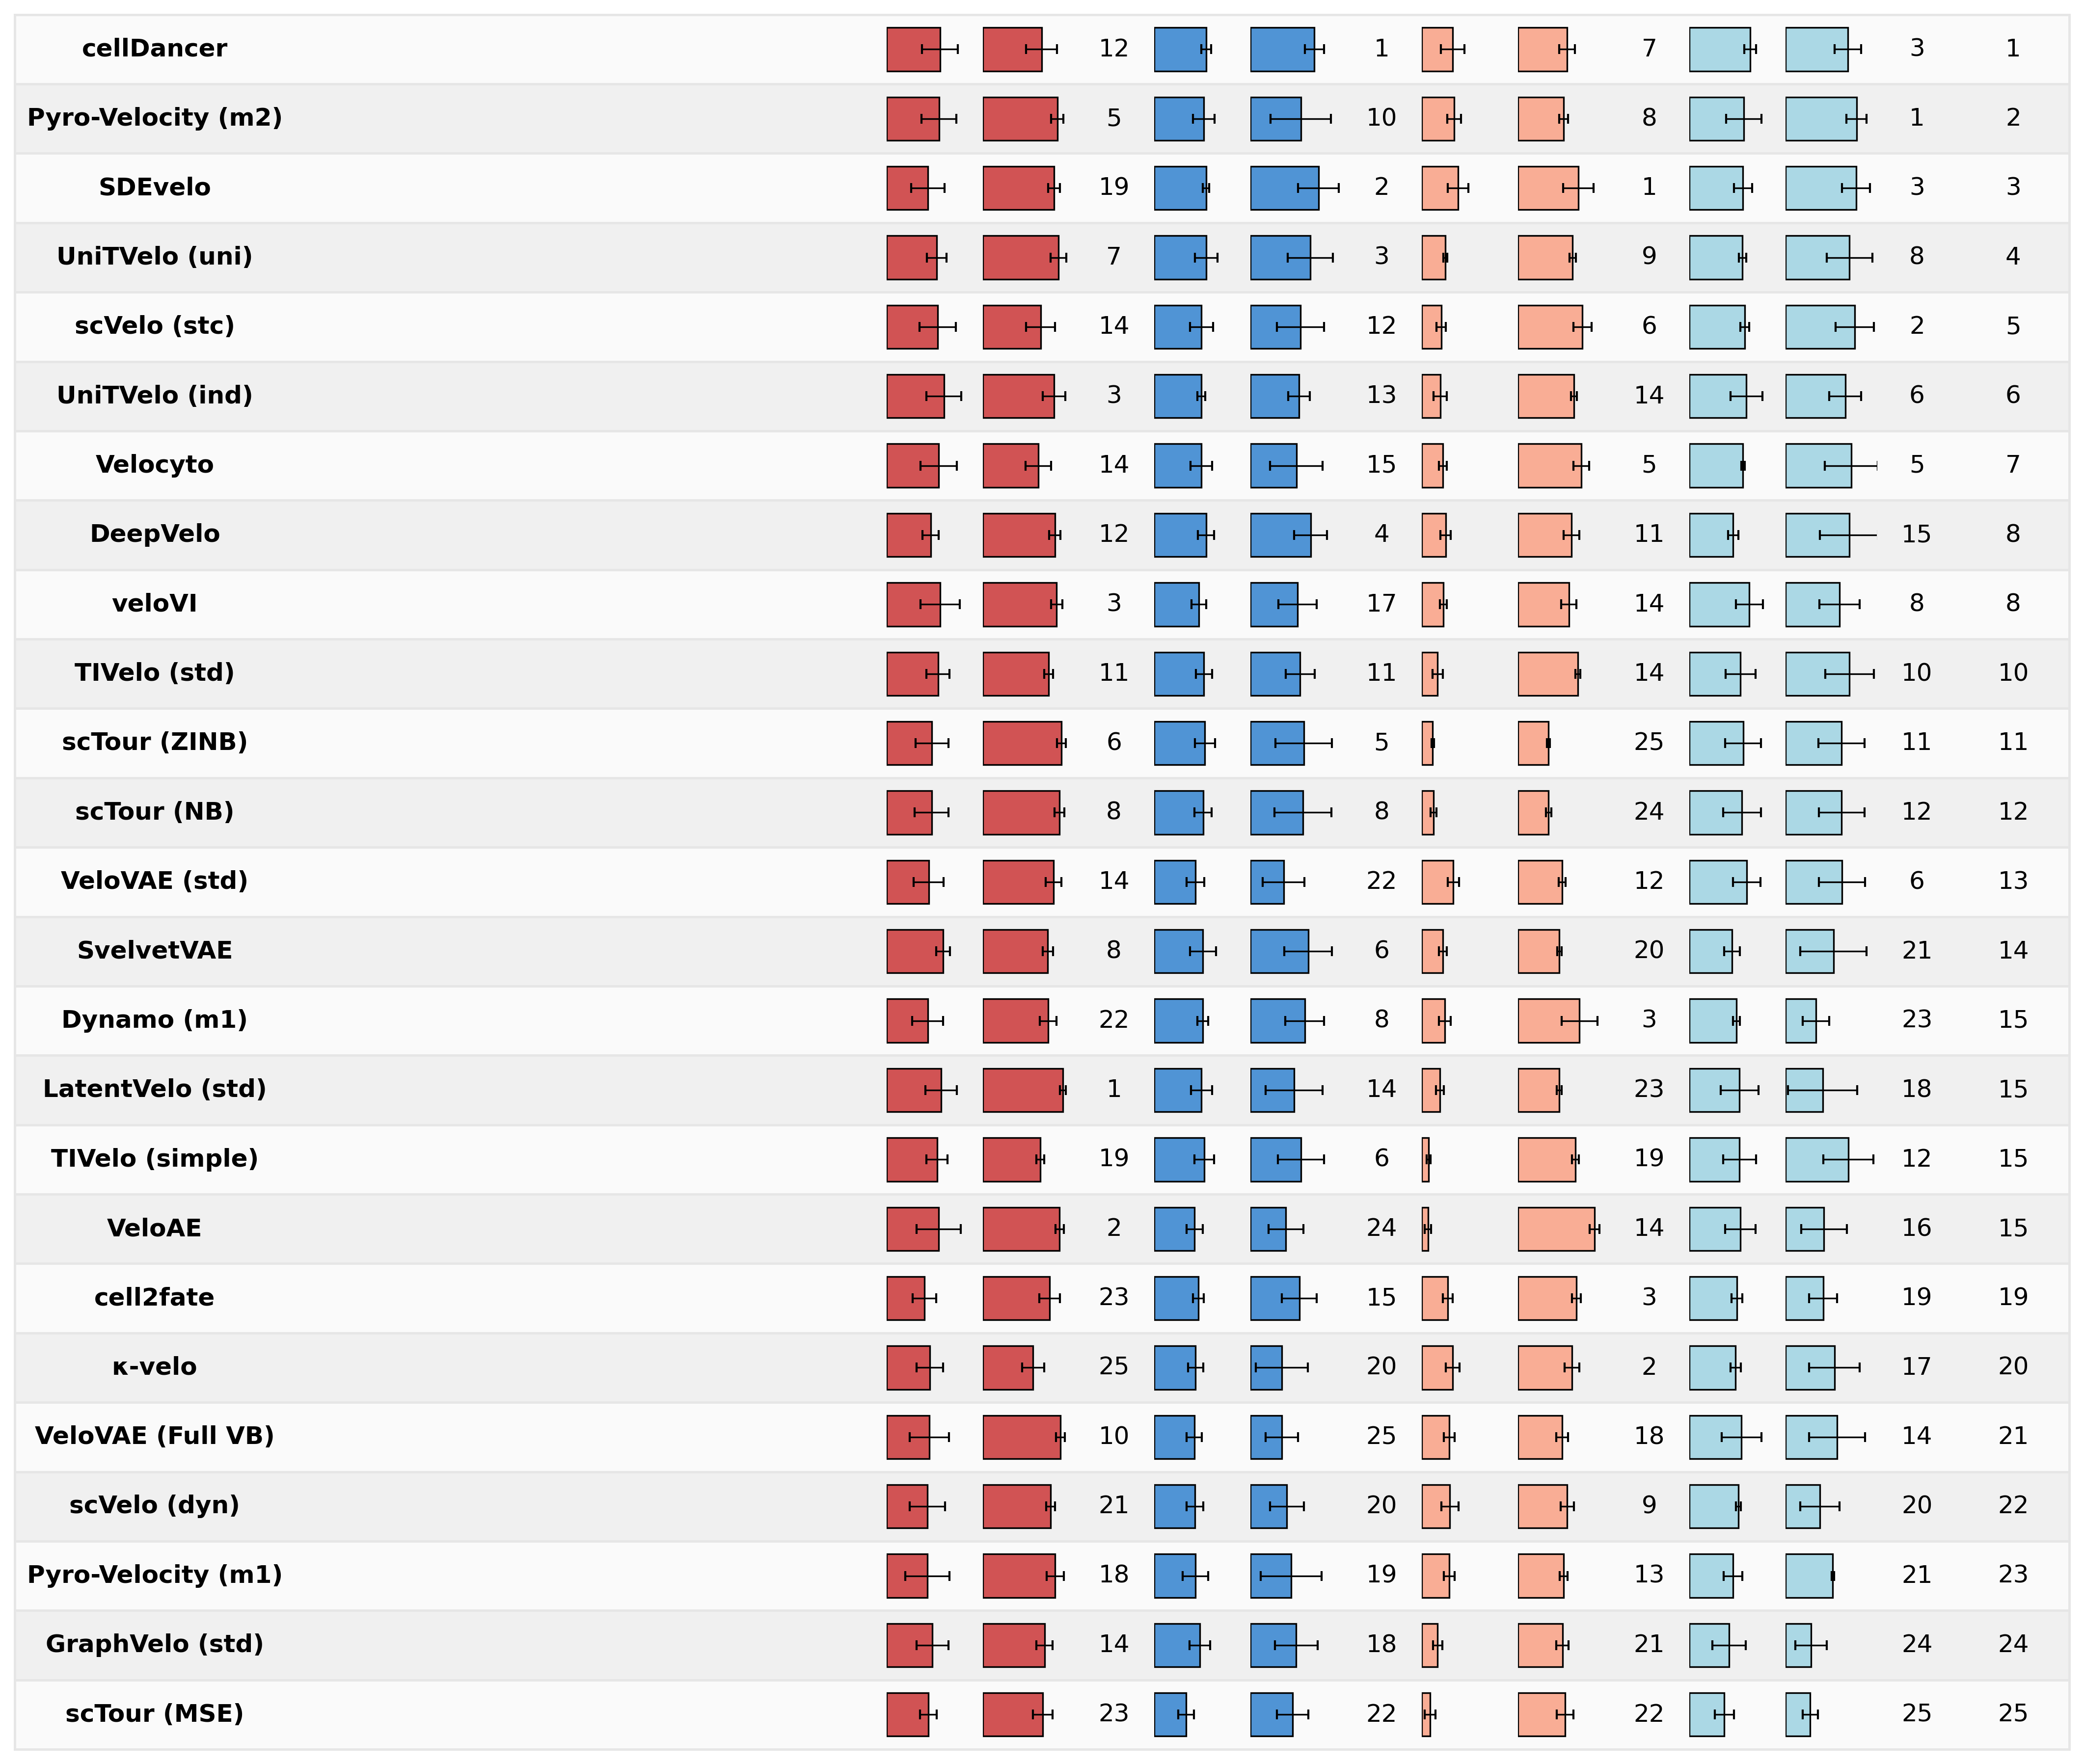

In [14]:
# 假设你已经有 df_1, df_2, df_3, df_4
width_ratios = [2.0, 0.8, 0.8, 0.8, 0.8, 0.8,
                        0.65, 0.65, 0.5,
                        0.65, 0.65, 0.5,
                        0.65, 0.65, 0.5,
                        0.65, 0.65, 0.5,
                        0.8]
fig, master = plot_four_metric_grid(
    df_1, df_2, df_3, df_4,
    width_ratios=width_ratios,
    group_colors=( "#D15354","#5094D5","#F9AD95", "#ABD8E5"),  # 四个三列块的配色
    text_colors=( "black","black","black", "black"),
    bar_alpha =1.0,
    vlims={
        # 如果分数尺度不同，可单独设范围；否则会自动按数据适配
        "df1_m1": (0,1), "df1_m2": (0,1),
        "df2_m1": (0,1), "df2_m2": (0,1),
        "df3_m1": (0,1), "df3_m2": (0,1),
        "df4_m1": (0,1), "df4_m2": (0,1),
    },
    fontsize=12,
    dpi=300,
    show_header=False,
    method_rename_dict=method_rename_dict,
    show_method_names=True,
)
fig.savefig("summary_table.svg", bbox_inches="tight")
